In [2]:
#check Pytorch
!module avail pytorch


----------------------- /share/module.7/machine-learning -----------------------
   pytorch/1.0    pytorch/1.3    pytorch/1.5.1    pytorch/1.7.0
   pytorch/1.1    pytorch/1.5    pytorch/1.6.0    pytorch/1.8.1 (D)

  Where:
   D:  Default Module

Use "module spider" to find all possible modules.
Use "module keyword key1 key2 ..." to search for all possible modules matching
any of the "keys".


>

In [3]:
#Load Pytorch
!module load python3/3.8.6
!module load pytorch/1.7.0
!module load torch


The following have been reloaded with a version change:
  1) python3/3.8.10 => python3/3.8.6



In [4]:
# Imports here
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2

import torch
from torch.autograd import Variable
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split, Sampler, BatchSampler 
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from PIL import Image
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

## Load the data
 For Loading the data to this code, Please download the archive.zip and then create a folder named Data and to subfolder named training and testing and put related .csv in those folder

In [5]:
data_dir = 'Data'
train_dir = data_dir + '/training/fashion-mnist_train.csv'
test_dir = data_dir + '/testing/fashion-mnist_test.csv'

In [6]:
#Read Data
train_data = pd.read_csv(train_dir)
test_data = pd.read_csv(test_dir)

# Adding image ids
#train_data.insert(loc=0, column='image_id', value=np.arange(train_data.shape[0]))
#test_data.insert(loc=0, column='image_id', value=np.arange(train_data.shape[0],train_data.shape[0]+test_data.shape[0] ))

#train_data.to_csv(train_dir,index=False)
#test_data.to_csv(test_dir,index=False)


train_data.label

0        2
1        9
2        6
3        0
4        3
        ..
59995    9
59996    1
59997    8
59998    8
59999    7
Name: label, Length: 60000, dtype: int64

In [7]:
class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
            # first column is of labels.
            label.append(i[1])
            image.append(i[2:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Transform data into Tensor that has a range from 0 to 1
train_set = FashionDataset(train_data, transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_data, transform=transforms.Compose([transforms.ToTensor()]))
test_loader = DataLoader(test_set, batch_size=100)
print(np.size(train_set.images,0),np.size(train_set.images,1),np.size(train_set.images,2))
print(np.size(test_set.images,0),np.size(test_set.images,1),np.size(test_set.images,2))

60000 28 28
10000 28 28


## Cross validation

In [9]:
class ImageSampler(Sampler):
    def __init__(self, 
                 sample_idx,
                 data_source='Data/training/fashion-mnist_train.csv'):
        super().__init__(data_source)
        self.sample_idx = sample_idx
        self.df_images = pd.read_csv(data_source)
        
    def __iter__(self):
        image_ids = self.df_images['image_id'].loc[self.sample_idx]
        return iter(image_ids)
    
    def __len__(self):
        return len(self.sample_idx)

In [10]:
class ImageBatchSampler(BatchSampler):
    def __init__(self, 
                 sampler,
                 aug_count=4,
                 batch_size=100,
                 drop_last=True):
        super().__init__(sampler, batch_size, drop_last)
        self.aug_count = aug_count
        assert self.batch_size % self.aug_count == 0, 'Batch size must be an integer multiple of the aug_count.'
        
    def __iter__(self):
        batch = []
        
        for image_id in self.sampler:
            for i in range(self.aug_count):
                batch.append(image_id)
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        if len(batch) > 0 and not self.drop_last:
            yield batch
    
    def __len__(self):
        if self.drop_last:
            return len(self.sampler) // self.batch_size
        else:
            return (len(self.sampler) + self.batch_size - 1) // self.batch_size

In [11]:
def create_split_loaders(dataset, split, aug_count, batch_size):
    train_folds_idx = split[0]
    valid_folds_idx = split[1]
    train_sampler = ImageSampler(train_folds_idx)
    valid_sampler = ImageSampler(valid_folds_idx)
    train_batch_sampler = ImageBatchSampler(train_sampler, 
                                            aug_count, 
                                            batch_size)
    valid_batch_sampler = ImageBatchSampler(valid_sampler, 
                                            aug_count=1, 
                                            batch_size=batch_size,
                                            drop_last=False)
    train_loader = DataLoader(dataset, batch_sampler=train_batch_sampler)
    valid_loader = DataLoader(dataset, batch_sampler=valid_batch_sampler)
    return (train_loader, valid_loader)    

In [12]:
def get_all_split_loaders(dataset, cv_splits, aug_count=4, batch_size=100):
    """Create DataLoaders for each split"""
    split_samplers = []
    
    for i in range(len(cv_splits)):
        split_samplers.append(
            create_split_loaders(dataset,
                                 cv_splits[i], 
                                 aug_count, 
                                 batch_size)
        )
    return split_samplers

In [13]:
splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

splits = []
for train_idx, test_idx in splitter.split(train_data['image_id'],train_data['label']):
    splits.append((train_idx, test_idx))

In [14]:
dataloaders = get_all_split_loaders(train_set, splits, aug_count=4, batch_size=1000)

In [45]:
#print(len(train_batch_loader),len(valid_batch_loader))

40 20


# Building the classifier

In [40]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=576, out_features=200)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=200, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [41]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=200, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=200, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


## Training the classifier

In [42]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
train_loss_list = []
valid_loss_list = []
iteration_list = []
train_accuracy_list = []
valid_accuracy_list = []
train_predictions_list = []
valid_predictions_list =[]
train_labels_list = []
valid_labels_list =[]
for train_batch_loader, valid_batch_loader in dataloaders:
    for epoch in range(num_epochs):
        train_correct = 0
        train_total = 0
        train_loss = 0
        for images, labels in train_batch_loader:
            # Transfering images and labels to GPU if available
            images, labels = images.to(device), labels.to(device)
            train_labels_list.append(labels)

            train = Variable(images.view(1000, 1, 28, 28))
            labels = Variable(labels)

            # Forward pass 
            outputs = model(train)
            loss = error(outputs, labels)
            train_loss = loss.data
            train_loss_list.append(train_loss)
            
            predictions = torch.max(outputs, 1)[1].to(device)
            train_predictions_list.append(predictions)
            train_correct = (predictions == labels).sum()
            train_total = len(labels)
            train_accuracy = train_correct * 100 / train_total
            train_accuracy_list.append(train_accuracy)


            # Initializing a gradient as 0 so there is no mixing of gradient among the batches
            optimizer.zero_grad()

            #Propagating the error backward
            loss.backward()

            # Optimizing the parameters
            optimizer.step()

            count += 1

            # Turn off gradients for validation, saves memory and computation
            with torch.no_grad():
            # Set the model to evaluation mode
                model.eval()

                # Validation pass
                valid_total = 0
                valid_correct = 0
                valid_loss = 0

                for images, labels in valid_batch_loader:
                    images, labels = images.to(device), labels.to(device)
                    valid_labels_list.append(labels)

                    validation = Variable(images.view(1000, 1, 28, 28))

                    outputs = model(validation)

                    valid_loss += error(outputs, labels)

                    predictions = torch.max(outputs, 1)[1].to(device)
                    valid_predictions_list.append(predictions)
                    valid_correct += (predictions == labels).sum()

                    valid_total += len(labels)

                model.train()
                valid_accuracy = valid_correct * 100 / valid_total
                valid_accuracy_list.append(valid_accuracy)
                valid_loss_list.append(valid_loss/len(valid_batch_loader))
                iteration_list.append(count)

                
        print("Iteration: {}, Train_Loss: {}, Valid_Loss: {}, Train_Accuracy: {}, Valid_Accuracy: {}%".format(count, train_loss, valid_loss/len(valid_batch_loader), train_accuracy, valid_accuracy))


Iteration: 160, Train_Loss: 0.43542203307151794, Valid_Loss: 0.38678663969039917, Train_Accuracy: 82.4000015258789, Valid_Accuracy: 86.10499572753906%
Iteration: 320, Train_Loss: 0.3879086673259735, Valid_Loss: 0.3722144067287445, Train_Accuracy: 84.70000457763672, Valid_Accuracy: 86.88999938964844%
Iteration: 480, Train_Loss: 0.33934566378593445, Valid_Loss: 0.33827537298202515, Train_Accuracy: 85.4000015258789, Valid_Accuracy: 87.7249984741211%
Iteration: 640, Train_Loss: 0.304734468460083, Valid_Loss: 0.31665730476379395, Train_Accuracy: 88.30000305175781, Valid_Accuracy: 88.60499572753906%
Iteration: 800, Train_Loss: 0.31000617146492004, Valid_Loss: 0.30500760674476624, Train_Accuracy: 87.30000305175781, Valid_Accuracy: 89.04999542236328%
Iteration: 960, Train_Loss: 0.26970168948173523, Valid_Loss: 0.26703569293022156, Train_Accuracy: 89.20000457763672, Valid_Accuracy: 90.48500061035156%
Iteration: 1120, Train_Loss: 0.2458857297897339, Valid_Loss: 0.26934537291526794, Train_Accurac

Text(0, 0.5, 'Loss value')

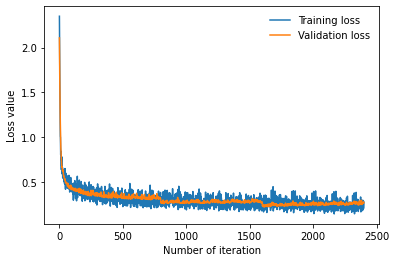

In [51]:
plt.plot(train_loss_list, label = "Training loss")
plt.plot(valid_loss_list, label = "Validation loss")
plt.legend(frameon = False)
plt.xlabel("Number of iteration")
plt.ylabel("Loss value")

Text(0, 0.5, 'Accuracy percentage')

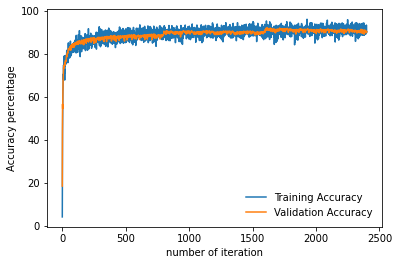

In [50]:
plt.plot(train_accuracy_list, label = "Training Accuracy")
plt.plot(valid_accuracy_list, label = "Validation Accuracy")
plt.legend(frameon = False)
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy percentage")

## Testing

In [46]:

# Do validation on the test set
model.eval()
model.to(device)
test_loss_list = []
test_accuracy_list = []
test_predictions_list =[]
test_labels_list =[]

with torch.no_grad():

    total = 0
    correct = 0
    test_loss = 0
    accuracy = 0

    for images, labels in test_loader:

        images, labels = images.to(device), labels.to(device)
        test_labels_list.append(labels)

        test = Variable(images.view(100, 1, 28, 28))

        outputs = model(test)

        probabilities = torch.exp(outputs)

        test_loss += error(outputs, labels)

        predictions = torch.max(outputs, 1)[1].to(device)
        test_predictions_list.append(predictions)
        correct += (predictions == labels).sum()

        total += len(labels)

    accuracy = correct * 100 / total
    test_accuracy_list.append(accuracy)
    test_loss_list.append(test_loss/len(test_loader))


print("Test Accuracy: {}".format(accuracy/len(test_loader))) 

Test Accuracy: 0.8937999606132507


## Confision Matrix

In [47]:

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

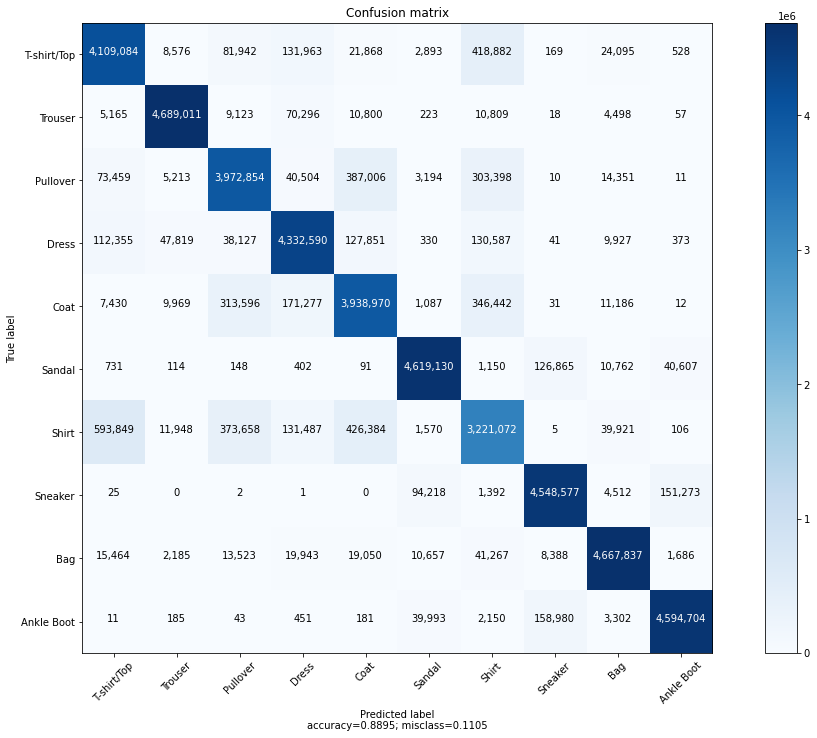

In [48]:
from sklearn.metrics import confusion_matrix
y_true = np.array([i.cpu().detach().numpy() for i in valid_labels_list]).flatten()
y_pred = np.array([i.cpu().detach().numpy() for i in valid_predictions_list]).flatten()
cm=confusion_matrix(y_true=y_true, y_pred=y_pred, labels=None, sample_weight=None, normalize=None)
target = ["T-shirt/Top", "Trouser","Pullover","Dress","Coat", "Sandal", "Shirt","Sneaker","Bag","Ankle Boot"]
plot_confusion_matrix(cm, target_names=target, normalize=False)

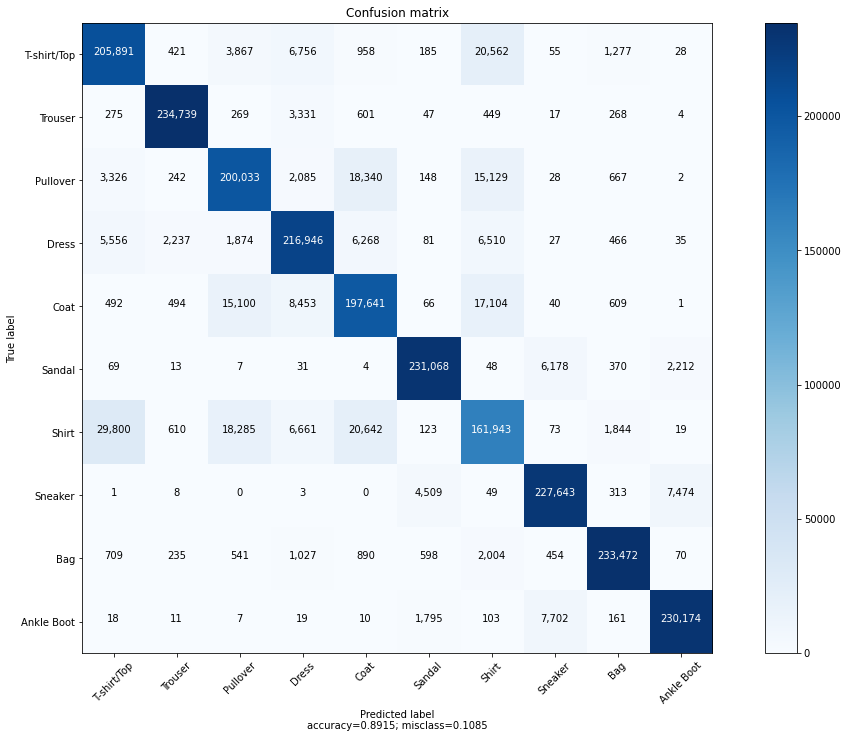

In [49]:
y_true = np.array([i.cpu().detach().numpy() for i in train_labels_list]).flatten()
y_pred = np.array([i.cpu().detach().numpy() for i in train_predictions_list]).flatten()
cm1=confusion_matrix(y_true=y_true, y_pred=y_pred, labels=None, sample_weight=None, normalize=None)
plot_confusion_matrix(cm1, target_names=target, normalize=False)

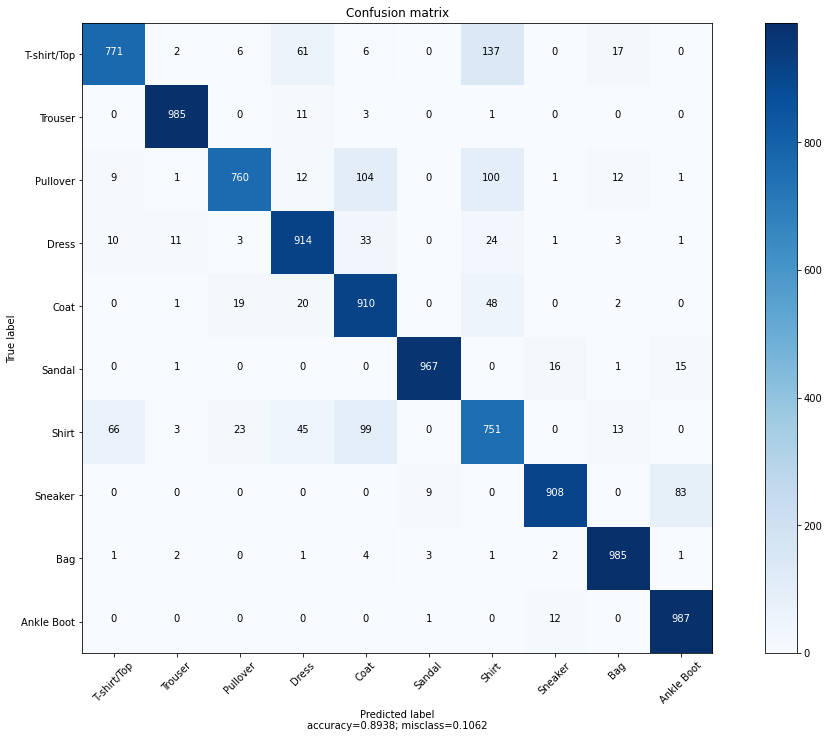

In [52]:
y_true = np.array([i.cpu().detach().numpy() for i in test_labels_list]).flatten()
y_pred = np.array([i.cpu().detach().numpy() for i in test_predictions_list]).flatten()
cm2=confusion_matrix(y_true=y_true, y_pred=y_pred, labels=None, sample_weight=None, normalize=None)
plot_confusion_matrix(cm2, target_names=target, normalize=False)